In [379]:
import qutip
# TODO implement this to make sure notebook runs correctly and can reproduce plots
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/lectures/Lecture-10-cQED-dispersive-regime.ipynb

In [380]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Options, about, basis, coherent, correlation, destroy,
                   expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)

%matplotlib widget

In [381]:
class experiment:
    #todo add init
    N = 10

    #todo add functions in class
    #todo clean up so not as messy looking, below is all variables
    wr = 2.0 * 2 * np.pi  # resonator frequency
    wq = 2.0 * 2 * np.pi  # qubit frequency
    chi = 0.025 * 2 * np.pi  # parameter in the dispersive hamiltonian

    #initial vals TODO move to init
    qubDrivAmp = 1
    cavDrivAmp = 2

    tlist = np.linspace(0, 250, 100)

    delta = abs(wr - wq)  # detuning
    g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

    # cavity operators
    a = tensor(destroy(N), qeye(2))
    nc = a.dag() * a
    xc = a + a.dag()

    # atomic operators
    sm = tensor(qeye(N), destroy(2))
    sz = tensor(qeye(N), sigmaz())
    sx = tensor(qeye(N), sigmax())
    nq = sm.dag() * sm
    xq = sm + sm.dag()

    Id = tensor(qeye(N), qeye(2))
    psi0 = tensor(basis(N, 0), (basis(2, 0)).unit())
       
    # H0 is the time-independent part
    H0 = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi *(a.dag() * a + Id / 2) * sz

    # H1 + are the time-dependent terms
    #qubit
    qubitH = sm.dag() + sm

    # NOTE this does not use RWA 

    # TODO add ramp up time using tanh
    #TODO make param for h1 qubitDriveAmp, h2 cavity
    #VNApower
    def qub_coeff(self, t, args):
        wd = args['wd']
        return self.qubDrivAmp * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) 


    # H1 + are the time-dependent terms
    #cavity
    cavH = a.dag() + a

    # NOTE this does not use RWA 
    def cav_coeff(self, t, args):
        wd = args['wd']
        return self.cavDrivAmp * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) * 

    # TODO add collapse operators for qubit and cavity
    decayQ = .01
    c_ops = [np.sqrt(decayQ) * sm] #decays on qubit

    #recalculate master equation solver from global vars, returns nc_list and nq_list
    def masterSolve(self):
        H = [self.H0, [self.qubitH, self.qub_coeff], [self.cavH, self.cav_coeff]]

        res = mesolve(H, self.psi0, self.tlist, self.c_ops, [], options=Options(nsteps=5000), args=args)

        self.nc_list = expect(nc, res.states)
        self.nq_list = expect(nq, res.states)
        
    
    #plots Time vs N from nc_list and nq_list
    def plotN_time(self):
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))
        
        ax.plot(self.tlist, self.nc_list, "r", linewidth=2, label="cavity")
        ax.plot(self.tlist, self.nq_list, "b--", linewidth=2, label="qubit")
        ax.set_ylim(0, 7)
        ax.set_ylabel("n", fontsize=16)
        ax.set_xlabel("Time (ns)", fontsize=16)
        ax.legend()

        fig.tight_layout()

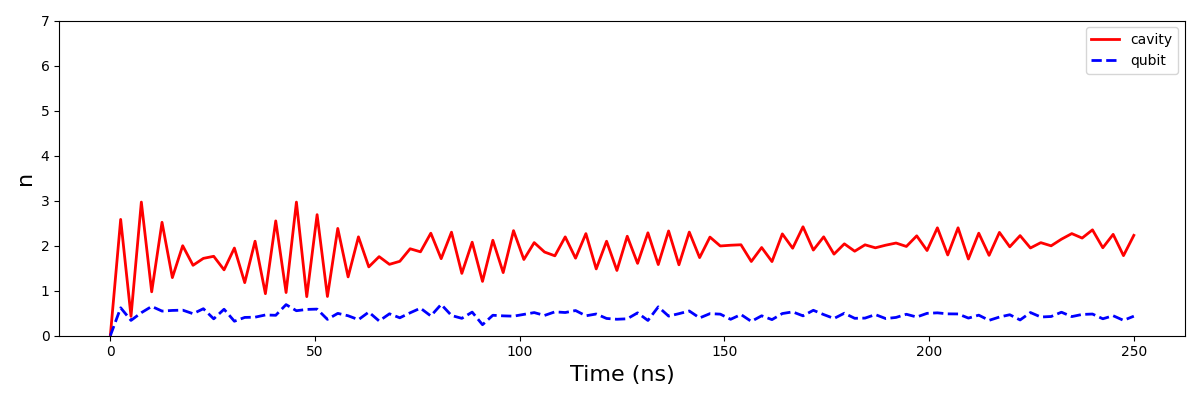

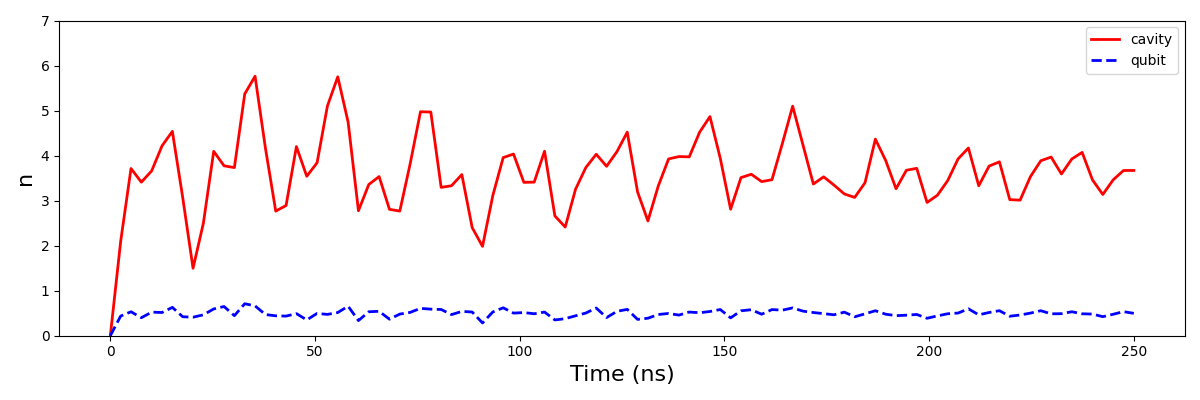

In [382]:
e = experiment()
e.masterSolve()
e.plotN_time()

#adjust params
e.N = 14
e.qubDrivAmp = 2
e.cavDrivAmp = 5
e.masterSolve()
e.plotN_time()



In [383]:
N =  10 # should be much larger than average photon occupancy (>x10)
# but as increase N sim will be slower -> decrease drive amplitudes
# or to increase kappa for faster decay

wr = 2.0 * 2 * np.pi  # resonator frequency
wq = 2.0 * 2 * np.pi  # qubit frequency
chi = 0.025 * 2 * np.pi  # parameter in the dispersive hamiltonian

#initial vals, adjusted by function
qubDrivAmp = 6
cavDrivAmp = 8

tlist = np.linspace(0, 250, 100)

delta = abs(wr - wq)  # detuning
g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

In [384]:
# compare detuning and g, the first should be much larger than the second
delta / (2 * np.pi), g / (2 * np.pi)

(0.0, 0.0)

In [385]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

Id = tensor(qeye(N), qeye(2))

In [386]:
# dispersive hamiltonian
# H0 is the time-independent part
H0 = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi *(a.dag() * a + Id / 2) * sz
# H0 = wr * (a.dag() * a) + wq * (sm.dag() * sm) + g* (a.dag()*sm + a*sm.dag())

# H1 + are the time-dependent terms
#qubit
qubitH = sm.dag() + sm

# NOTE this does not use RWA 

# TODO add ramp up time using tanh
#TODO make param for h1 qubitDriveAmp, h2 cavity
#VNApower
def qub_coeff(t, args):
    wd = args['wd']
    return qubDrivAmp * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) 


# H1 + are the time-dependent terms
#cavity
cavH = a.dag() + a

# NOTE this does not use RWA 
def cav_coeff(t, args):
    wd = args['wd']
    return cavDrivAmp * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) * 

# TODO add collapse operators
decayQ = .01
c_ops = [np.sqrt(decayQ) * sm]

H = [H0, [qubitH, qub_coeff], [cavH, cav_coeff]]

In [387]:
psi0 = tensor(basis(N, 0), (basis(2, 0)).unit())

In [388]:

args = {'wd': wq+.1*wq}
res = mesolve(H, psi0, tlist, c_ops, [], options=Options(nsteps=4000), args=args)



In [389]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

In [390]:
# TODO plot steady state n value in qubit drive frequency domain

In [391]:
print(nc_list[-1])

3.8929017049877115


In [392]:
print(nc_list[-1])

3.8929017049877115
